# Bond Premium, Curve Height, and Combined

In [101]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from data import COUNTRIES, get_all_data_and_labels
from indicators import *
from signal_math import *
from stats import *
from utils import *

plt.rcParams["figure.figsize"] = (16, 4)

# Initialize the data
all_data, all_labels = get_all_data_and_labels()
all_data_clean, all_labels_clean = get_all_data_and_labels(cleaned=True)

for i, label in enumerate(all_labels):
    vars()[label] = all_data[i]
    
for i, label in enumerate(all_labels_clean):
    vars()[label] = all_data_clean[i]
    
print(*all_labels, sep='\n')

# Get daily returns benchmark
bond_rets_daily = bond_rets_local_fx.pct_change()

bond_rets_local_fx
equity_prices
curr_acct_nom_usd
curr_acct_pct_gdp
fx_trd_wts_nom
fx_trd_wts_real
fx_vs_usd
fx_to_usd
gdp_nom
gdp_real
short_rates
long_rates
core_cpi_sa
m1_usd
m2_usd
m3_usd
inflation_rate_annual
bond_premium
curve_height


The prospectus claims that bond risk premium is positively related to bond returns, and that curve height is also positively related to bond returns (in conjunction with premium).

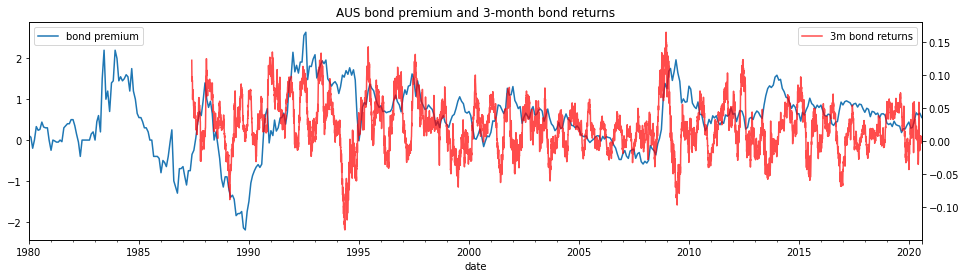

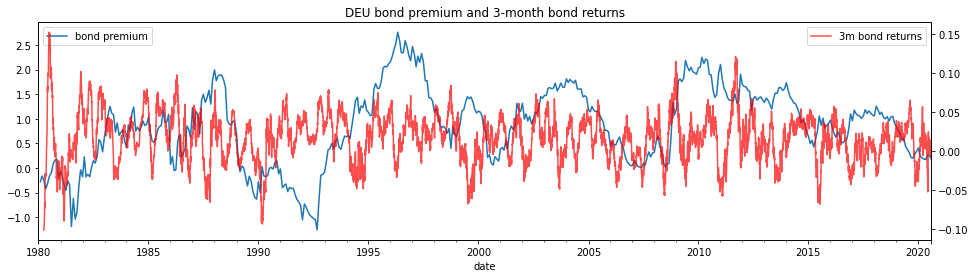

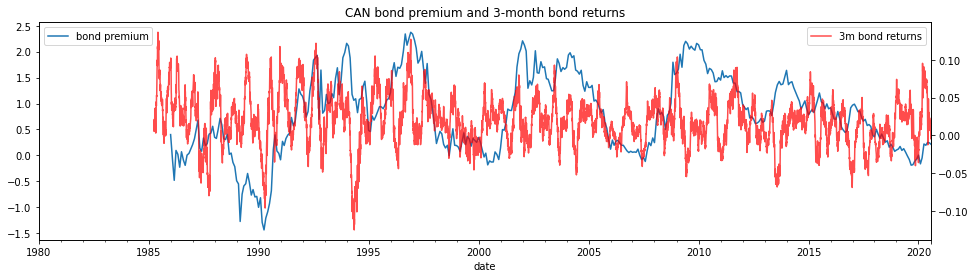

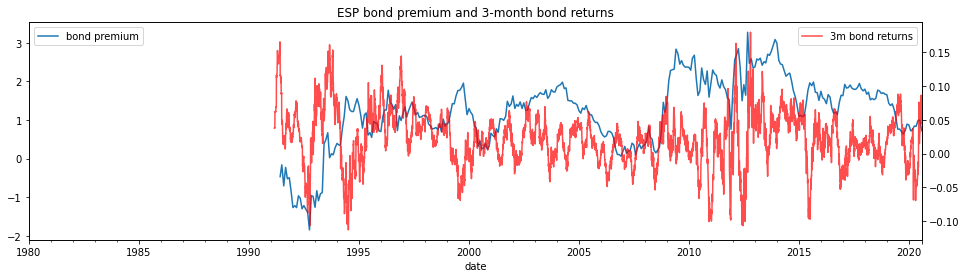

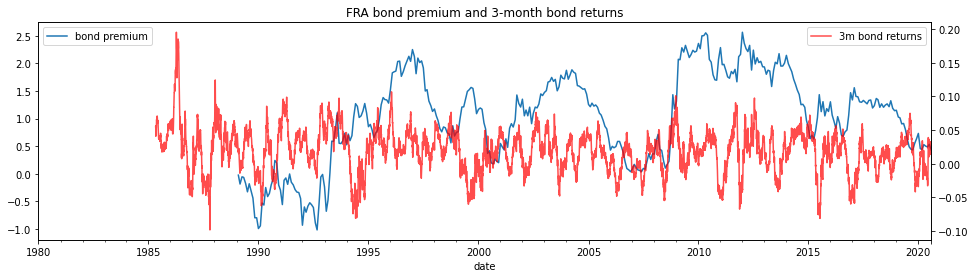

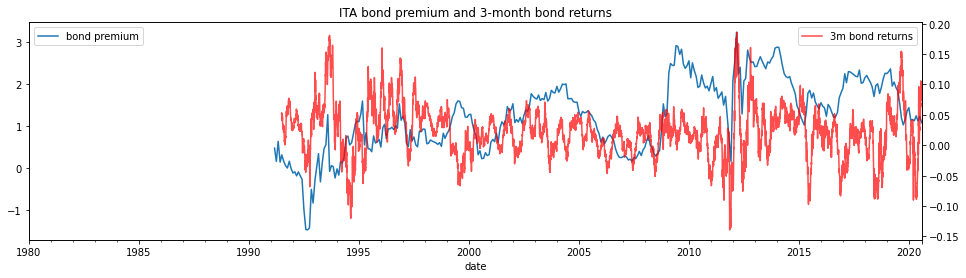

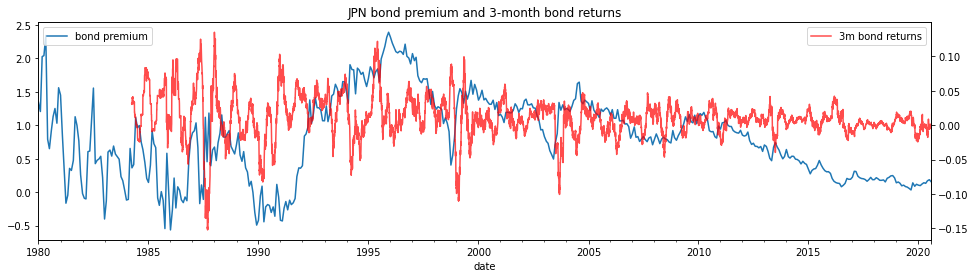

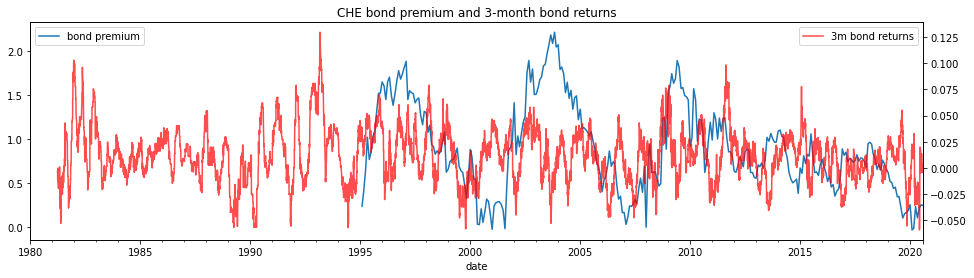

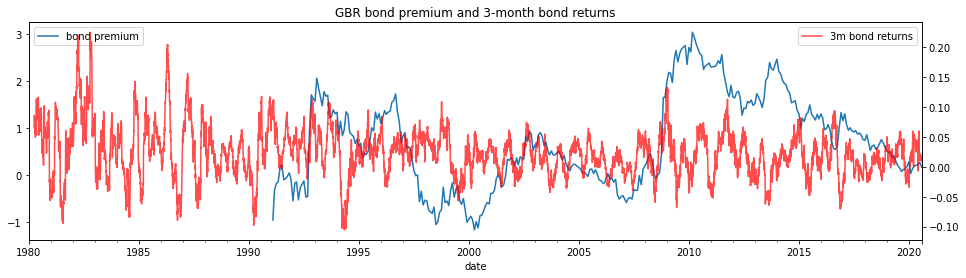

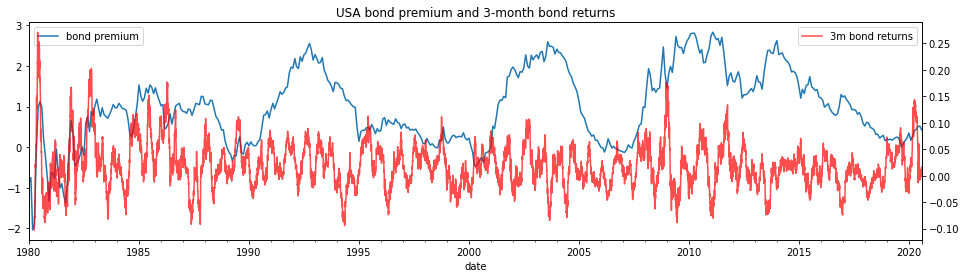

In [105]:
bond_rets_3m = bond_rets_local_fx.pct_change(3 * WEEKDAYS_PER_MONTH)
for country in bond_premium:
    fig, ax = plt.subplots()
    bond_premium[country].plot()
    ax2 = bond_rets_3m[country].plot(style='red', alpha=0.7, secondary_y=True)
    ax.set_title(f'{country} bond premium and 3-month bond returns')
    ax.legend(['bond premium'], loc='upper left')
    ax2.legend(['3m bond returns'], loc='upper right')


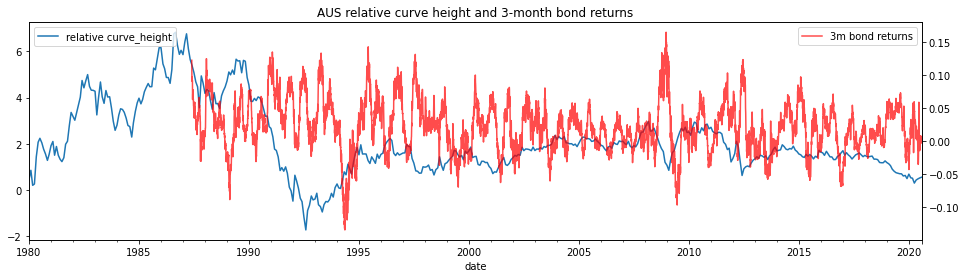

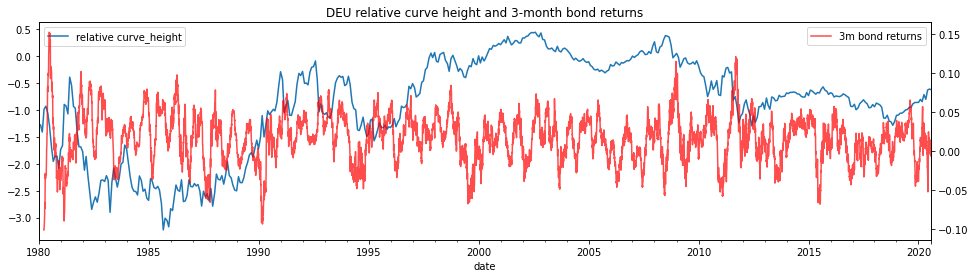

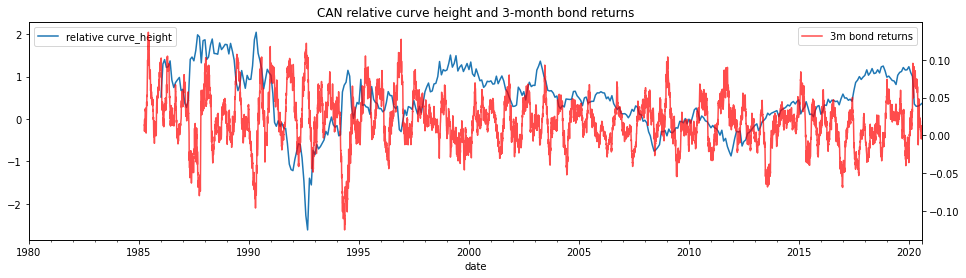

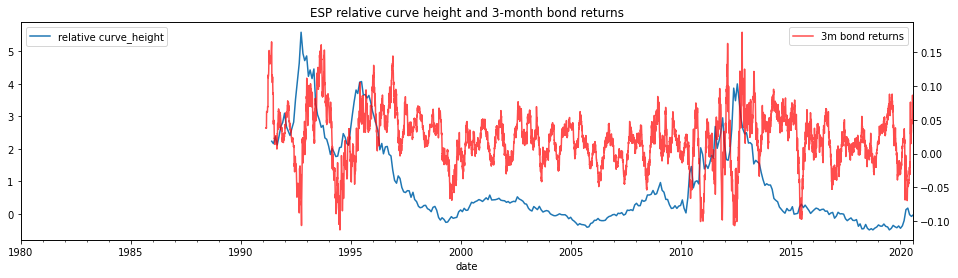

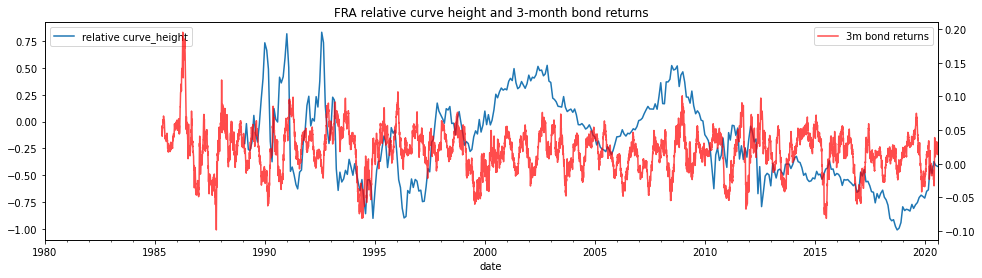

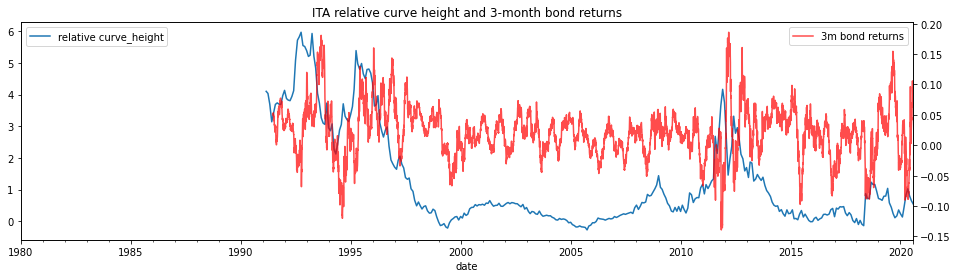

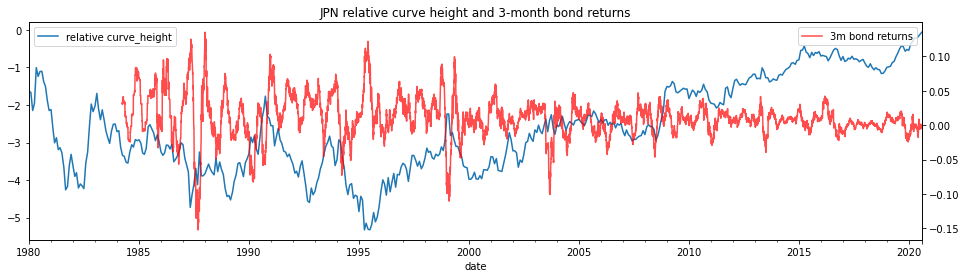

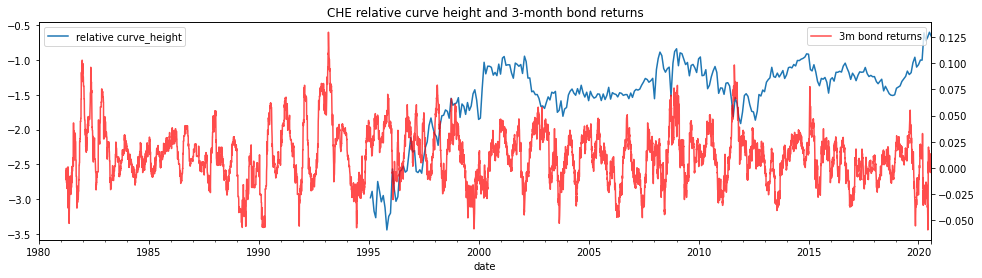

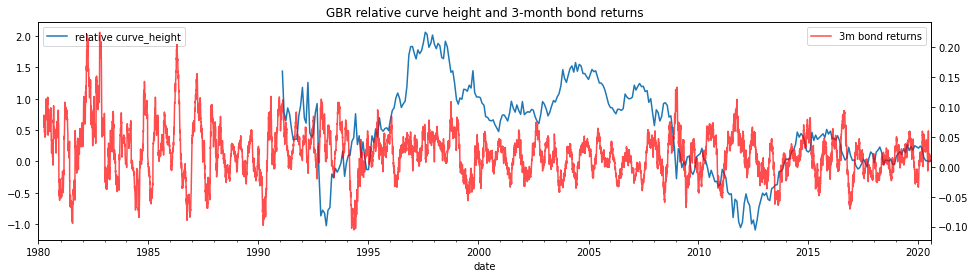

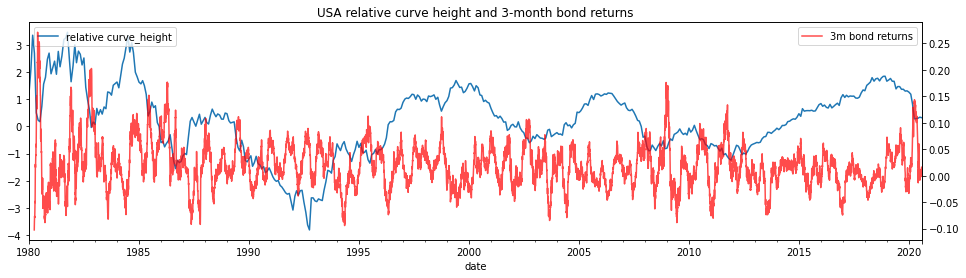

In [106]:
curve_height_relative = curve_height.sub(curve_height.mean(axis=1), axis=0)
for country in bond_premium:
    fig, ax = plt.subplots()
    curve_height_relative[country].plot()
    ax2 = bond_rets_3m[country].plot(style='red', alpha=0.7, secondary_y=True)
    ax.set_title(f'{country} relative curve height and 3-month bond returns')
    ax.legend(['relative curve_height'], loc='upper left')
    ax2.legend(['3m bond returns'], loc='upper right')

## Bond Premium

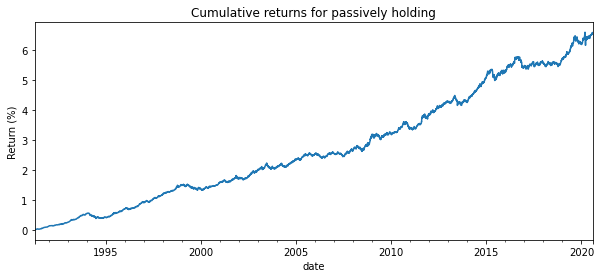

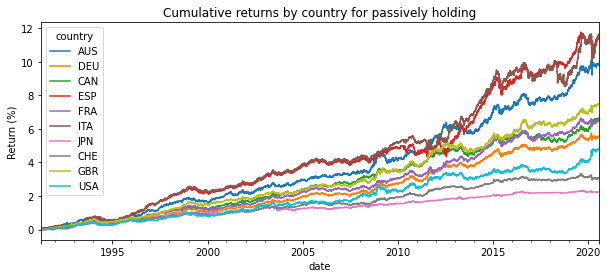

In [19]:
# Cumulative returns from holding
((1 + bond_rets_daily.dropna().mean(axis=1)).cumprod() - 1).plot(
    title='Cumulative returns for passively holding',
    ylabel='Return (%)'
)

((1 + bond_rets_daily.dropna()).cumprod() - 1).plot(
    title='Cumulative returns by country for passively holding',
    ylabel='Return (%)'
)

plt.show()

Cumulative returns are massive for the passively holding strategy (even larger if you start from 1980, before there is data for all countries), so this will prove challenging to even come close to.

Because our strategy works is trying to pick over and underperformers, it theoretically should work best when there are more countries in play. For that reason, we are calculating returns since 1991, the first year we have return data for all countries.

I faithfully implement the prospectus' component for bond premium:

- Compute $\text{Premium} = \text{Long Rates} - \text{Short Rates}$

- Compute the relative premium for each country by subtracting the global average

- Standardize that relative premium to each country's history of the indicator

Though, I don't plan to use each indicator directly as a signal, for the purposes of testing, I convert the indicator to a signal and calculate cumulative returns.


Total cumulative return: 0.25483701583642415
Cumulative return by country: country
AUS   -0.214919
DEU   -0.259466
CAN    0.020578
ESP    1.599486
FRA    0.441806
ITA    1.194394
JPN    0.191063
CHE   -0.008885
GBR    0.122538
USA    0.238506
dtype: float64


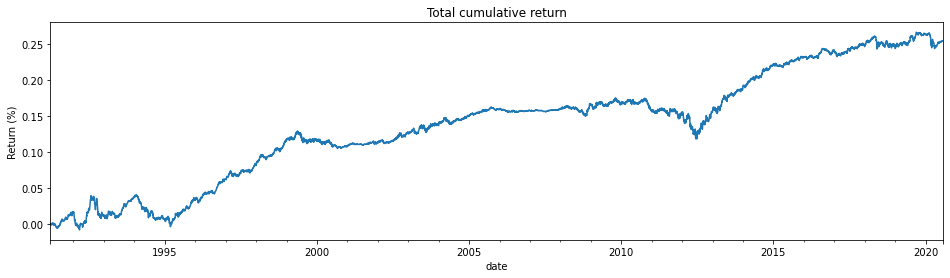

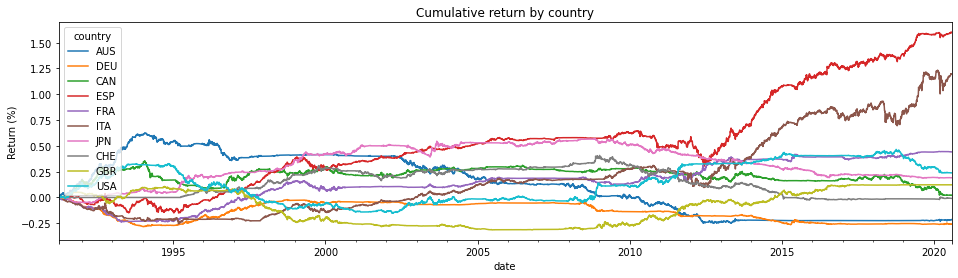

In [107]:
# Compute the signals (and indicators)
inds, sigs = test_indicator(
    bond_premium_indicator,
    index=long_rates.index,
    data=(long_rates, short_rates)
)

# Calculate returns

total_rets, country_rets = calculate_returns(*make_comparable(sigs, bond_rets_daily))
print('Total cumulative return:', (1 + total_rets).product() - 1)
print('Cumulative return by country:', (1 + country_rets).product() - 1)

# Plot
((1 + total_rets).cumprod() - 1).plot(
    title='Total cumulative return',
    ylabel='Return (%)'
)
((1 + country_rets).cumprod() - 1).plot(
    title='Cumulative return by country',
    ylabel='Return (%)'
)
plt.show()

Total cumulative return: 0.26712948000747305
Cumulative return by country: country
AUS   -0.185388
DEU   -0.208216
CAN    0.032860
ESP    1.837952
FRA    0.473514
ITA    1.137351
JPN    0.018896
CHE    0.029092
GBR    0.141571
USA    0.236382
dtype: float64


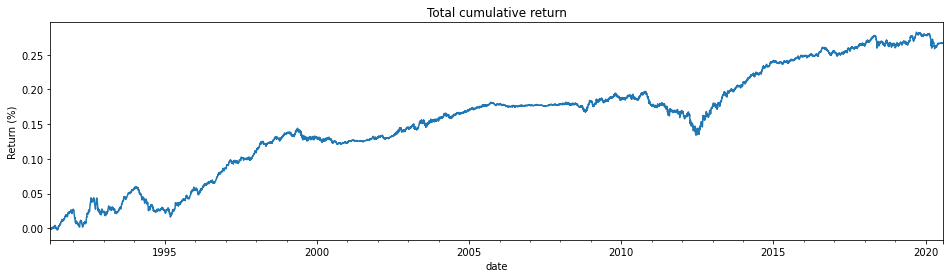

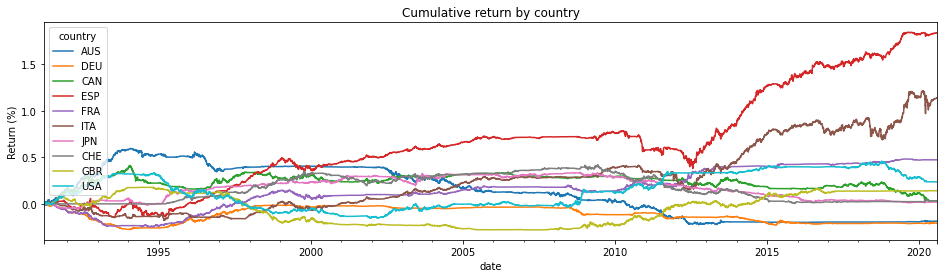

In [108]:
# Try with denoised data for fun
inds, sigs = test_indicator(
    bond_premium_indicator,
    index=long_rates_clean.index,
    data=(long_rates_clean, short_rates_clean)
)

total_rets, country_rets = calculate_returns(*make_comparable(sigs, bond_rets_daily))
print('Total cumulative return:', (1 + total_rets).product() - 1)
print('Cumulative return by country:', (1 + country_rets).product() - 1)

((1 + total_rets).cumprod() - 1).plot(
    title='Total cumulative return',
    ylabel='Return (%)'
)
((1 + country_rets).cumprod() - 1).plot(
    title='Cumulative return by country',
    ylabel='Return (%)'
)
plt.show()

The cumulative returns are clearly abysmal. Want to investigate possible adjustments to the indicator, and if there is any reason for it performing better or worse on different countries and different times.

One hypothesis for the extent of the low cumulative returns is that the signal is likely relatively weak across the board. The method I use to generate a trading signal from an indicator moves smoothly (and asymptotically) between $-1$ and $1$, which will hurt the results since I'm taking relatively small positions.

To test this hypothesis let's see if we can boost the signal by snapping to $-1$ or $1$ if the signal is above or below a threshold.

We'll try a simple MCMC optimization to find good threshold numbers (see `stats/mcmc.py` for my implementation).

In [68]:
def obj_fn(coef):
    _, sigs = test_indicator(
        bond_premium_indicator,
        index=long_rates_clean.index,
        data=(long_rates_clean, short_rates_clean)
    )

    sigs[sigs > coef[0]] = 1
    sigs[sigs < coef[1]] = -1
    
    total_rets, _ = calculate_returns(*make_comparable(sigs, bond_rets_daily))
    return (1 + total_rets).product() - 1


def change_fn(coef, *args):
    coef += np.random.normal(scale=0.1, size=len(coef))
    coef[0] = np.clip(coef[0], 0, 1)
    coef[1] = np.clip(coef[1], -1, 0)
    return coef

In [69]:
coef, ret = mcmcOptimizer(np.array([0.5, -0.5]), obj_fn, change_fn, n_iters=30, verbose=True)

New best: 0.45504861192855794 with coefficients: [ 0.39888822 -0.63473547]
3% done, best_obj=0.45504861192855794, best_coef=[ 0.39888822 -0.63473547]
New best: 0.4872992573011452 with coefficients: [ 0.37380138 -0.75679416]
New best: 0.515775054935244 with coefficients: [ 0.35075218 -0.85756226]
10% done, best_obj=0.515775054935244, best_coef=[ 0.35075218 -0.85756226]
New best: 0.5514034873792717 with coefficients: [ 0.32863792 -0.96017322]
16% done, best_obj=0.5514034873792717, best_coef=[ 0.32863792 -0.96017322]
New best: 0.5628002695156091 with coefficients: [ 0.22846418 -0.72040109]
New best: 0.5826010486405901 with coefficients: [ 0.19953673 -0.72713412]
23% done, best_obj=0.5826010486405901, best_coef=[ 0.19953673 -0.72713412]
New best: 0.5839377981026854 with coefficients: [ 0.15107748 -0.50413545]
30% done, best_obj=0.5839377981026854, best_coef=[ 0.15107748 -0.50413545]
New best: 0.660594341290933 with coefficients: [ 0.10017083 -0.53059838]
36% done, best_obj=0.66059434129093

Unfortunately, the fact that it is approaching `[0, -1]` likely indicates that just that going long on as much as possible is best. So, while the signals are weak, the short signals are not correct better than chance (which favors going long).

## Curve Height

I faithfully implement the prospectus' component for bond premium:

- Compute $\text{Curve Height} = \frac{\text{Long Rates} + \text{Short Rates}}{2}$

- Compute the relative curve height for each country by subtracting the global average

- Standardize that relative curve height to each country's history of the indicator


Total cumulative return: -0.043882878063483344
Cumulative return by country: country
AUS   -0.618032
DEU    2.263417
CAN   -0.314648
ESP   -0.351207
FRA   -0.140271
ITA   -0.344321
JPN    0.043113
CHE    0.670688
GBR    0.095019
USA   -0.113580
dtype: float64


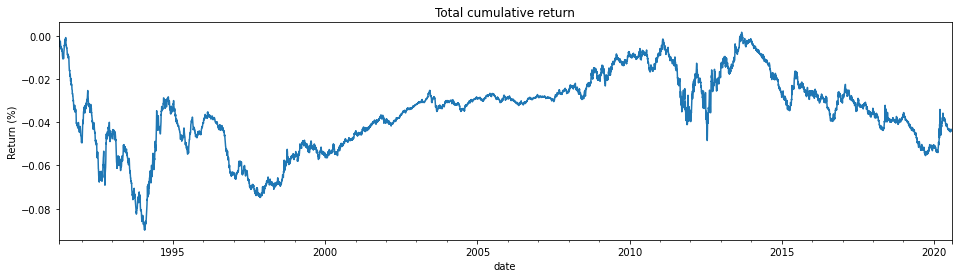

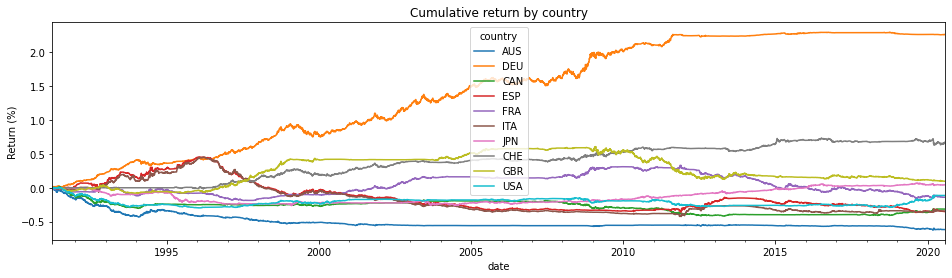

In [109]:
# Compute the signals (and indicators)
inds, sigs = test_indicator(
    curve_height_indicator,
    index=long_rates.index,
    data=(long_rates, short_rates)
)

# Calculate returns
total_rets, country_rets = calculate_returns(*make_comparable(sigs, bond_rets_daily))
print('Total cumulative return:', (1 + total_rets).product() - 1)
print('Cumulative return by country:', (1 + country_rets).product() - 1)

# Plot
((1 + total_rets).cumprod() - 1).plot(
    title='Total cumulative return',
    ylabel='Return (%)'
)
((1 + country_rets).cumprod() - 1).plot(
    title='Cumulative return by country',
    ylabel='Return (%)'
)
plt.show()

Interestingly enough, the curve height indicator would do better if it were inverted (i.e., `-1 * signal`). The prospectus claims that high relative curve height should bring rates down and therefore raise returns, but that seems to not be the case even at the scale of this indicator's measly returns.

It also does so much better in Germany than anywhere else. Can I find a causal relationship there?

## Bond Premium and Curve Height Combination

The prospectus hypothesizes that a relatively high bond premium and high curve height will lead to a decline in interest rates and therefore an increase in returns, while a high bond premium and low curve height will lead to a rise in interest rates and therefore a decrease in returns.

For my bond premium and curve height combination, I multiplied the two indicators together. Based on the description above, if they are moving in the same direction this should be good and opposite directions should be bad. However I found that not to be the case empirically; multiplying the bond premium indicator by the negative curve height indicator produced the best results. I need to further investigate why this could be the case (is there a relationship or is it simply a function of probability?).

Total cumulative return: 0.6352711275249623
Cumulative return by country: country
AUS    0.572436
DEU    0.256401
CAN    0.378613
ESP    0.980938
FRA    0.493677
ITA    0.901423
JPN    0.540883
CHE    0.045794
GBR    1.446564
USA    0.997225
dtype: float64


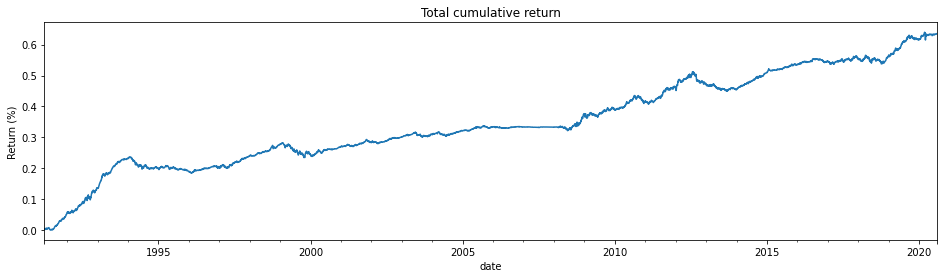

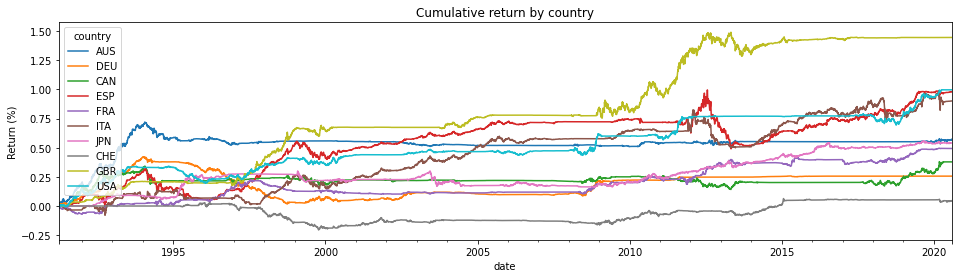

In [110]:
# Compute the signals (and indicators)
inds, sigs = test_indicator(
    bond_premium_and_curve_height_indicator,
    index=long_rates.index,
    data=(long_rates, short_rates)
)

# Calculate returns
total_rets, country_rets = calculate_returns(*make_comparable(sigs, bond_rets_daily))
print('Total cumulative return:', (1 + total_rets).product() - 1)
print('Cumulative return by country:', (1 + country_rets).product() - 1)

# Plot
((1 + total_rets).cumprod() - 1).plot(
    title='Total cumulative return',
    ylabel='Return (%)'
)
((1 + country_rets).cumprod() - 1).plot(
    title='Cumulative return by country',
    ylabel='Return (%)'
)
plt.show()

The returns here are really driven by performance in the Britain. I need to investigate why this is the case.

In [73]:
# Can we boost the signal
def obj_fn(coef):
    _, sigs = test_indicator(
        bond_premium_and_curve_height_indicator,
        index=long_rates.index,
        data=(long_rates, short_rates)
    )

    sigs[sigs > coef[0]] = 1
    sigs[sigs < coef[1]] = -1
    
    total_rets, _ = calculate_returns(*make_comparable(sigs, bond_rets_daily))
    return (1 + total_rets).product() - 1


def change_fn(coef, *args):
    coef += np.random.normal(scale=0.1, size=len(coef))
    coef[0] = np.clip(coef[0], 0, 1)
    coef[1] = np.clip(coef[1], -1, 0)
    return coef

coef, ret = mcmcOptimizer(np.array([0.5, -0.5]), obj_fn, change_fn, n_iters=30, verbose=True)

New best: 0.7484258291445081 with coefficients: [ 0.55132028 -0.58003775]
3% done, best_obj=0.7484258291445081, best_coef=[ 0.55132028 -0.58003775]
New best: 0.8483076365155202 with coefficients: [ 0.3982414  -0.55976622]
New best: 0.8583348680039429 with coefficients: [ 0.38006686 -0.45536047]
10% done, best_obj=0.8583348680039429, best_coef=[ 0.38006686 -0.45536047]
16% done, best_obj=0.8583348680039429, best_coef=[ 0.38006686 -0.45536047]
23% done, best_obj=0.8583348680039429, best_coef=[ 0.38006686 -0.45536047]
New best: 0.916816298020025 with coefficients: [ 0.34037957 -0.75396287]
30% done, best_obj=0.916816298020025, best_coef=[ 0.34037957 -0.75396287]
36% done, best_obj=0.916816298020025, best_coef=[ 0.34037957 -0.75396287]
43% done, best_obj=0.916816298020025, best_coef=[ 0.34037957 -0.75396287]
50% done, best_obj=0.916816298020025, best_coef=[ 0.34037957 -0.75396287]
56% done, best_obj=0.916816298020025, best_coef=[ 0.34037957 -0.75396287]
63% done, best_obj=0.916816298020025

Again, this seems to just want to approach `[0, -1]`. Indeed:

In [76]:
obj_fn([0, -1])

2.2495790295380322

Which still falls far below passively holding at `6.58`.